In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

/home/js7561/dev/miniconda3/envs/py35hpc/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Define pescador data generators for train/validate/test

In [5]:
import pescador
from scipy.stats import zscore
import gzip
import os
import fnmatch

In [6]:
def batch_mux(streams, batch_size, n_samples=None, n_active=1000,
              with_replacement=False):
    '''
    Multiplex streams into batches of size n_batch

    Parameters
    ----------
    streams : list of pescador.Streamer
        The list of streams to multiplex
    batch_size : int > 0
        Number of samples to in each batch (batch size)
    n_samples : int or None
        Number of individual samples to generate (limit). If None, generate
        infinite number of samples (unless with_replacement is False in which
        case generate until all streams are exhausted)
    n_active : int > 0
        Number of streams that can be active simultaneously
    with_replacement : bool
        If true sample form streams indefinitely. If False streams are sampled
        until exhausted.

    Returns
    -------
    batch_streamer : pescador.Streamer
        Batch multiplexer
    '''

    stream_mux = pescador.Streamer(
        pescador.mux, streams, n_samples, n_active,
        with_replacement=with_replacement)

    batch_streamer = pescador.Streamer(
        pescador.buffer_streamer, stream_mux, batch_size)

    return batch_streamer

In [7]:
def mil_bag_generator(cqtfile, actfile, n_bag_frames, min_active_frames, n_hop_frames, 
                      zscore_std=False, shuffle=True):
    '''
    Generate a MIL bag with corresponding label. 
    The function yields a dictionary with three elements: 
    X = features, Y = label, Z = bag ID (trackid + first frame index).

    Parameters
    ----------
    cqtfile : str
        Path to .npy.gz file containing the log-CQT matrix
    actfile : str
        Path to .npy.gz file containing the activation vector
    n_bag_frames : int
        Number of frames to include in a bag
    min_active_frames: int
        Minimum number of consecutive active frames to consider bag positive
    n_hop_frames : int
        Number of frames to jump between consecutive bags
    zscore : bool
        Whether or not to standardize the bag features (zscore)
    shuffle : bool
        Whether to shuffle the ordering of the bags (for sgd) or not (for
        validation and test)

    Returns
    -------
    bag : dictionary with X = features, Y = label, Z = bag ID
    '''
    # Load cqt file and ativation file
    cqt = np.load(gzip.open(cqtfile, 'rb'))
    act = np.load(gzip.open(actfile, 'rb'))

    order = np.arange(0, cqt.shape[1]-n_bag_frames, n_hop_frames) # librosa puts time in dim 1
    # Randomize frame order
    if shuffle:
        np.random.shuffle(order)
    # Get bag ID (from filename)
    trackid = '_'.join(os.path.basename(cqtfile).split('_')[:2])

    for frame in order:
        
        # Carve out TF patch, standardize (optional) and reshape
        patch = cqt[:, frame:frame + n_bag_frames]
        if zscore_std:
            patch = zscore(patch, axis=None)
        patch = patch.reshape(-1, patch.shape[0], patch.shape[1], 1)
        
        # Compute bag label
        patch_act = act[frame:frame+n_bag_frames]
        condition = patch_act >= 0.5
        # The following computes the length of every consecutive sequence
        # of True's in condition:
        active_lengths = np.diff(np.where(np.concatenate(
            ([condition[0]], condition[:-1] != condition[1:], [True])))[0])[::2]
        # Need at least min_active_frames to consider bag as positive
        if len(active_lengths) > 0:
            bag_label = 1 * (active_lengths.max() >= min_active_frames)
        else:
            bag_label = 0
        
        # Compute bag ID
        bagid = '{:s}_{:d}'.format(trackid, frame)    
        
        yield dict(
            X=patch,
            Y=np.asarray([bag_label], dtype=np.int32),
            ID=np.asarray([bagid]))

In [22]:
def vad_minibatch_generator(root_folder, track_list,
                            augmentations=['original'],
                            feature='cqt44100_1024_8_36', 
                            activation='vocal_activation44100_1024',
                            n_bag_frames=44,
                            min_active_frames=2,
                            n_hop_frames=22,
                            zscore_std=False,
                            shuffle=True,
                            batch_size=100, 
                            n_samples=None,
                            n_active=1000,
                            with_replacement=False):
    """

    Parameters
    ----------
    root_folder
    track_list
    augmentations
    feature
    activation
    n_bag_frames
    min_activate_frames
    n_hop_frames
    zscore_std
    shuffle
    batch_size
    n_samples
    n_active
    with_replacement

    Returns
    -------

    """
    # DEBUG
    print("Collecting feature files...")
    
    # Collect all feature files
    cqt_files = []
    for aug in augmentations:
        aug_folder = os.path.join(root_folder, aug, 'features', feature)
        for root, dirnames, filenames in os.walk(aug_folder):
            for filename in fnmatch.filter(filenames, '*cqt.npy.gz'):
                cqt_files.append(os.path.join(root, filename))
                
    # DEBUG
    print("Found {:d} files".format(len(cqt_files)))
    print("Creating streams...")

    # Turn all files into streams
    streams = []
    for cqtfile in cqt_files:
        # get matching activation file
        actfolder = os.path.join(os.path.dirname(os.path.dirname(cqtfile)), activation)
        actfile = os.path.join(actfolder, os.path.basename(cqtfile).replace('_cqt.npy.gz', 
                                                                            '_vocalactivation.npy.gz'))
        assert os.path.isfile(actfile)
        streams.append(pescador.Streamer(mil_bag_generator, cqtfile, actfile,
                                         n_bag_frames, min_active_frames, n_hop_frames, 
                                          zscore_std, shuffle))
        
    # DEBUG
    print("Done")

    # Mux the streams into minimbatches
    batch_streamer = batch_mux(streams, batch_size, n_samples=n_samples,
                               n_active=n_active, 
                               with_replacement=with_replacement)

    return batch_streamer

## Keras-compatible generators

In [26]:
def keras_vad_minibatch_generator(root_folder, track_list,
                                  augmentations=['original'],
                                  feature='cqt44100_1024_8_36', 
                                  activation='vocal_activation44100_1024',
                                  n_bag_frames=44,
                                  min_active_frames=2,
                                  n_hop_frames=22,
                                  zscore_std=False,
                                  shuffle=True,
                                  batch_size=100, 
                                  n_samples=None,
                                  n_active=1000,
                                  with_replacement=False):
    """

    Parameters
    ----------
    root_folder
    track_list
    augmentations
    feature
    activation
    n_bag_frames
    min_activate_frames
    n_hop_frames
    zscore_std
    shuffle
    batch_size
    n_samples
    n_active
    with_replacement

    Returns
    -------

    """
    keras_generator = vad_minibatch_generator(
        root_folder, track_list, augmentations, feature, activation,
        n_bag_frames, min_active_frames, n_hop_frames, zscore_std,
        shuffle, batch_size, n_samples, n_active, with_replacement)
    
    for batch in keras_generator.generate():
        yield (batch['X'], batch['Y'])

## Test generators

In [14]:
# test mil bag generator
cqtfile = '/scratch/js7561/datasets/MedleyDB_output/original/features/cqt44100_1024_8_36/ClaraBerryAndWooldog_AirTraffic_cqt.npy.gz'
actfile = '/scratch/js7561/datasets/MedleyDB_output/original/features/vocal_activation44100_1024/ClaraBerryAndWooldog_AirTraffic_vocalactivation.npy.gz'

In [15]:
gen = mil_bag_generator(cqtfile, actfile, n_bag_frames=44, min_active_frames=2, n_hop_frames=22,
                        zscore_std=False, shuffle=False)

In [16]:
for n, d in enumerate(gen):
    print(d['X'].shape, d['Y'].shape, d['ID'])

(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_0']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_22']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_44']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_66']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_88']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_110']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_132']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_154']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_176']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_198']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_220']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_242']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_264']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_286']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_308']
(1, 288, 44, 1) (1,) ['ClaraBerryAndWooldog_AirTraffic_330']
(1, 288, 44, 1) (1,) ['ClaraBe

In [17]:
d['Y']

array([0], dtype=int32)

In [18]:
d['X'].shape

(1, 288, 44, 1)

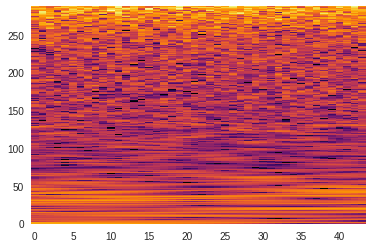

In [19]:
plt.imshow(d['X'].reshape(288,44), interpolation='nearest', aspect='auto', origin='lower', cmap='inferno')
plt.grid()

In [33]:
split = np.load('../data/dataSplits_7_1_2.pkl')

In [34]:
root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
track_list = split[2][0]
augmentations = ['original']
feature = 'cqt44100_1024_8_36'
activation = 'vocal_activation44100_1024'
n_bag_frames = 44
min_active_frames = 2
n_hop_frames = 22
zscore_std= False
shuffle = True
batch_size = 100
n_samples = None
n_active = 1000
with_replacement = False

train_generator = vad_minibatch_generator(
    root_folder, track_list, augmentations, feature, activation,
    n_bag_frames, min_active_frames, n_hop_frames, zscore_std,
    shuffle, batch_size, n_samples, n_active, with_replacement)

Found 122 files
Creating streams...
Done


In [35]:
for n, batch in enumerate(train_generator.generate()):
    print(n)
    if n==2:
        break

0
1
2


In [36]:
batch

{'ID': array(['MusicDelta_ChineseHenan_1254', 'LizNelson_Coldwar_6534',
        'MatthewEntwistle_DontYouEver_814', 'MusicDelta_ModalJazz_1342',
        'Phoenix_ColliersDaughter_2156', 'StrandOfOaks_Spacestation_6622',
        'JoelHelander_Definition_4488', 'NightPanther_Fire_4004',
        'MusicDelta_Pachelbel_748', 'BrandonWebster_DontHearAThing_6908',
        'ClaraBerryAndWooldog_Boys_770', 'MusicDelta_FreeJazz_4048',
        'ClaraBerryAndWooldog_AirTraffic_1254',
        'TablaBreakbeatScience_Animoog_4576', 'MusicDelta_FunkJazz_110',
        'SweetLights_YouLetMeDown_5082', 'MusicDelta_Country1_220',
        'Meaxic_TakeAStep_9284', 'TablaBreakbeatScience_CaptainSky_12100',
        'TablaBreakbeatScience_WhoIsIt_7964', 'Mozart_DiesBildnis_6446',
        'AimeeNorwich_Flying_1958', 'TheScarletBrand_LesFleursDuMal_572',
        'InvisibleFamiliars_DisturbingWildlife_3432',
        'MusicDelta_SpeedMetal_1034',
        'InvisibleFamiliars_DisturbingWildlife_3168',
        'Music

In [37]:
batch['ID'].shape

(100,)

In [38]:
batch['Y'].shape

(100,)

In [39]:
batch['X'].shape

(100, 288, 44, 1)

## Test keras generators

In [11]:
split = np.load('../data/dataSplits_7_1_2.pkl')

In [27]:
root_folder = '/scratch/js7561/datasets/MedleyDB_output/'
track_list = split[2][0]
augmentations = ['original']
feature = 'cqt44100_1024_8_36'
activation = 'vocal_activation44100_1024'
n_bag_frames = 44
min_active_frames = 2
n_hop_frames = 22
zscore_std= False
shuffle = True
batch_size = 100
n_samples = None
n_active = 1000
with_replacement = False

keras_train_generator = keras_vad_minibatch_generator(
    root_folder, track_list, augmentations, feature, activation,
    n_bag_frames, min_active_frames, n_hop_frames, zscore_std,
    shuffle, batch_size, n_samples, n_active, with_replacement)

In [28]:
for n, batch in enumerate(keras_train_generator):
    print(n)
    if n==2:
        break

Found 122 files
Creating streams...
Done
0
1
2


In [30]:
len(batch)

2

In [31]:
batch[0].shape

(100, 288, 44, 1)

In [32]:
batch[1].shape

(100,)

In [33]:
batch[1]

array([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0], dtype=int32)

In [34]:
batch[0]

array([[[[-17.97571517],
         [-17.66111457],
         [-17.37978215],
         ..., 
         [-15.10785507],
         [-15.0986385 ],
         [-15.11052728]],

        [[-15.97433237],
         [-15.81874789],
         [-15.65746198],
         ..., 
         [-16.8476115 ],
         [-16.75144267],
         [-16.68879553]],

        [[-16.55267306],
         [-16.33537028],
         [-16.13679379],
         ..., 
         [-17.50432298],
         [-17.50704486],
         [-17.44673481]],

        ..., 
        [[-22.16884238],
         [-17.45082124],
         [-18.74556558],
         ..., 
         [-20.81423752],
         [-17.82384716],
         [-20.67368333]],

        [[-21.76911367],
         [-21.43848457],
         [-21.78812891],
         ..., 
         [-24.74740715],
         [-20.80903011],
         [-23.93240885]],

        [[-21.15377974],
         [-22.71686296],
         [-28.08436281],
         ..., 
         [-23.51070283],
         [-26.20703531],
         [-